## Introducción al Aprendizaje de Máquinas: Clasificación. 

Aprendizaje de Máquinas. Modelos de Aprendizaje Supervisado de Clasificación.

### Objetivos Notebook Introducción al Aprendizaje de Máquinas Clasificación:

1. Proveer un ejemplo de aprendizaje de máquinas supervisado como lo es identificar una señal de compra y una señal de venta de acciones.
2. Mostrar en líneas generales como esta implementada la simulación de la serie del tipo de cambio EUR-Dólar.

### Índice. 

#### 1. Indicadores de Análisis Técnico. 
#### 2. Backtesting Estrategía.
#### 3. Simulación de la tasa de cambio usando el movimiento browniano geométrico. 
#### 4. Referencias.

#### 1. Índicadores de Análisis Técnico.  

En la librería de Technical Indicators disponible en el siguiente respositorio: https://github.com/MesaFlar/FLAR_Quant_Lib se han venido codificando algunos de los siguientes indicadores de análisis técnico:  

- MACD Oscillator. 
- Bandas de Bollinger.
- Índice de fuerza relativa.

Estos indicadores de análisis técnico se los puede considerar métodos de Clasificación en la medida de que se aplican sobre datos cuya variable de respuesta tienen una etiqueta. Si la estrategía obtuvo un retorno positivo o un retorno negativo en el horizonte. 

En el presente notebook se aplicarán los modelos de análisis técnico para encontrar señales de compra o venta de las tasas de cambio de USD a GBP y EUR a GBP. 

In [15]:
import os 
import numpy as np
import pandas as pd

In [16]:
# Celda para importar las series de las tasas de cambio desde yahoo finance. 
# Las siguientes Líneas de código nos permiten importar los datos de las monedas para después exportarlos en el archivo forex_data.csv 
# ticker = ["EURUSD=X", "GBPUSD=X"]
# forex_df = yf.download(ticker, start="2020-01-01", end="2025-02-14", interval="1d")
# forex_df = forex_df.loc[:, idx['Close',:]]
# forex_df = forex_df.droplevel(0, axis=1)
# forex_df.columns = ["GBPUSD", "EURUSD"]
# forex_df.to_csv("forex_data.csv")

In [17]:
# Importamos las librerías que necesitamos para el notebook
from scipy import stats
from librerias.Technical_Indicators import *
from librerias.Backtest import *
from librerias.extract_data import *
from librerias.finance_operators import calculateLogReturns
from librerias.graphs import *
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

### Get the Kolmogorov Smirnov threshold. 
from scipy.stats import kstwobign

idx = pd.IndexSlice 

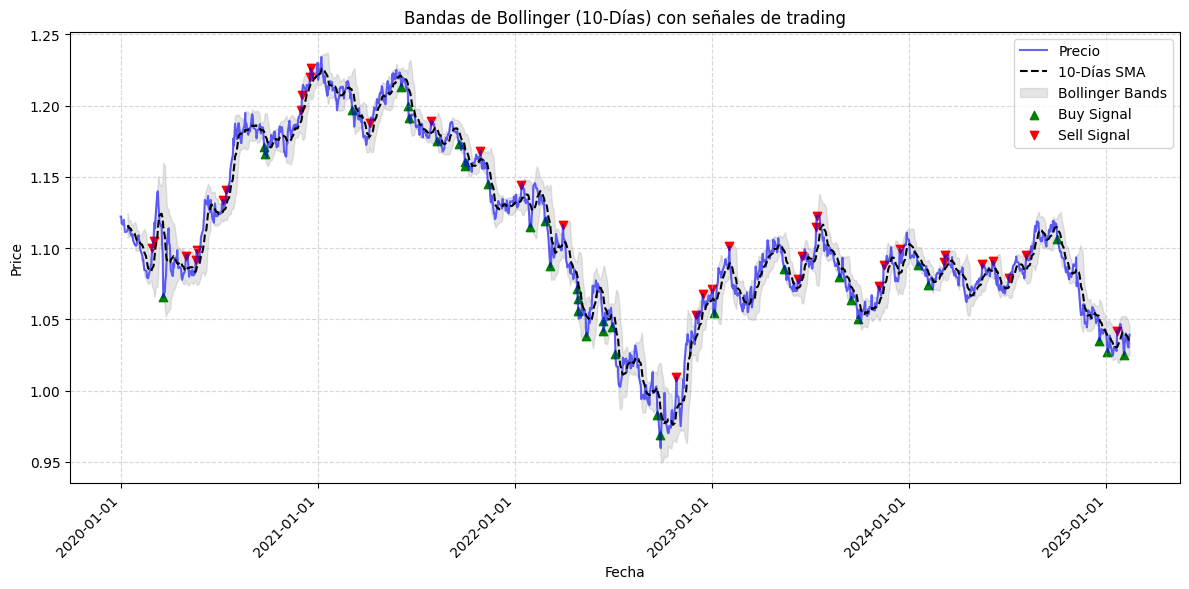

In [18]:
# Importamos entonces los datos de Forex.  
forex_df = pd.read_csv(os.path.join('datos\\'+'forex_data.csv'), encoding = 'utf-8', sep = ';', index_col = 0)

# Eliminamos los nans de la base de datos de forex_df según corresponda.
forex_df = forex_df.dropna()

# Empezamos a usar la implementación de la librería create_bollinger_band_signal para encontrar las señales de compra y de venta. Usando una ventana de 10 días para constuir la bande de bolinger las señales.  
signal = create_bollinger_band_signal(forex_df[['EURUSD','GBPUSD']],10)

# Creamos una copia del DataFrame para poder graficar dicha banda de Bollinger. 
forex_df_plot = forex_df.copy()
plot_bollinger_bands(forex_df_plot, column = "EURUSD", window = 10 )

#### 2. Backtesting. 

Una vez tenemos las señales de compra y ventas debemos realizar el backtesting. Para ello se cuenta con las siguientes etapas. 

1. Calcular las estadísticas descriptivas de la estrategía. 

a. Filtrar las señales. Suprime señales repetidas dentro de una ventana de window_size días. Es decir, si dentro de un período de window_size días ya se ha dado una señal, descarta las siguientes señales de la misma dirección.   

b. Encontrar el retorno de la señal en el horizonte. 

c. Obtener las estadísticas descriptivas.

2. Calcular el test de Kolmogrov-Smirnov. 

a. Conferir formato al DataFrame con señales de compra y de venta. 

b. Aplicar test de Kolmogorov Smirnov. 

In [19]:
# 1. Calcular las Estadísticas Descriptivas de la Estrategía. 
# Filtra las señales.   
filtered_signals = filter_signals(signal, lookahead_days = 20)
filtered_signals

# Encontrar el retorno del índice/moneda en el horizonte.  
lookahead_prices = get_lookahead_prices(forex_df, lookahead_days = 20)
lookahead_return = get_return_lookahead(forex_df, lookahead_prices)

# Obtener el retorno de la señal en el horizonte. 
signal_returns = get_signal_return(filtered_signals, lookahead_return)

# Eliminar aquellas fechas donde no se puede calcular el retorno.
signal_returns = signal_returns.dropna()
signal_returns

# Obtener estadísticas descriptivas de la estrategía. 
signal_returns.iloc[:-1000,:].describe()

,EURUSD,GBPUSD
count,316.000000,316.000000
mean,-0.000218,0.000138
std,0.003260,0.004220
min,-0.045990,-0.040278
25%,0.000000,0.000000
50%,0.000000,-0.000000
75%,0.000000,0.000000
max,0.018696,0.045152


In [20]:
# 2. Filtrar señales de compra y de venta 
long_short_signal_returns = signal_returns[signal_returns != 0].stack()
long_short_signal_returns = long_short_signal_returns.reset_index().iloc[:, [1,2]]
long_short_signal_returns.columns = ['ticker', 'signal_return']
long_short_signal_returns

### Filtrar aquellas observaciones que no tengan una señal de compra o de venta 
long_short_signal_returns.index = long_short_signal_returns['ticker']
long_short_signal_returns = long_short_signal_returns.iloc[:,1:]
long_short_signal_returns

,signal_return
ticker,
GBPUSD,0.016608
EURUSD,-0.004630
GBPUSD,0.004923
EURUSD,0.018696
EURUSD,-0.012135
...,...
EURUSD,-0.022233
GBPUSD,-0.017867
GBPUSD,0.003203


Calculo Test de Kolmogorov-Smirnov.

In [21]:
### Obtener los valores del estadístico de Kolmogorov-Smirnov
ksvalues, p_values = calculate_kstest(long_short_signal_returns)
### Obtener el intervalo crítico del test de Kolmogorov-Smirnov. 
alpha = 0.05
critical_value = kstwobign.ppf(1 - alpha) / np.sqrt(len(long_short_signal_returns))
outliers = find_outliers(ksvalues, p_values, critical_value)
outliers

c:\Users\jcamargo\CEFA_2025_env\lib\site-packages\numpy\core\fromnumeric.py:3502: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


set()

Como podemos apreciar en general las estrategías no generan retornos que sean significativamente superiores a los de la tasa de cambio en cuestión.

#### 3. Simulación de la tasa de cambio usando el modelo del Movimiento Browniano Geométrico. 

Para realizar una simulación del movimiento de la tasa de cambio de libra a dólar, primero revisamos algunas características de serie. 

* Graficar precio ajustado de la tasa de cambio de Libra a Dólar.
* Graficar histograma con los retornos logarítmicos de la tasa de cambio Libra a dólar. 
* Coeficiente de correlación entre los retornos de la tasa de cambio en t y los retornos de la tasa de cambio en t-1. 
* Simulación de la serie usando el modelo de movimiento browniano geométrico.



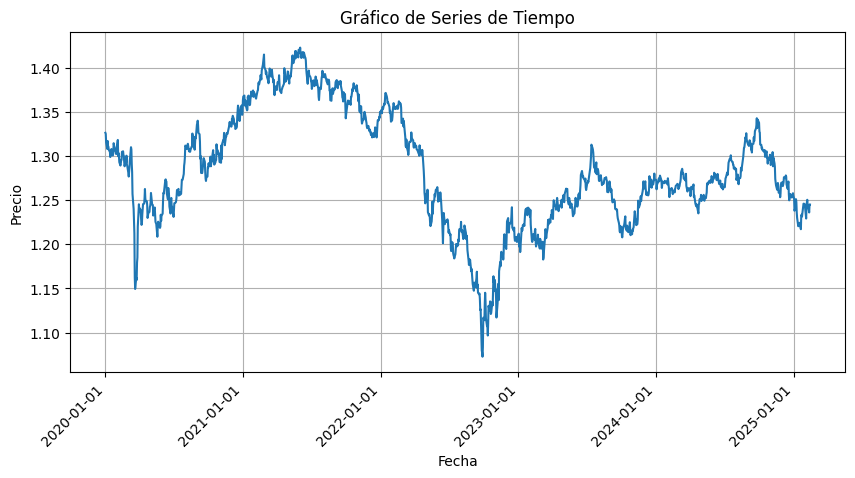

In [22]:
### Realizamos una segregación de la tasa de cambio libra a dólar.
GBP_USD = forex_df.loc[:,'GBPUSD']

### Obtenemos una copia de la serie para propositos del gráfico.
GBP_USD_plot = GBP_USD.copy() 
GBP_USD_plot.index = pd.to_datetime(GBP_USD_plot.index)
GBP_USD_plot

# 
fig = plot_time_series(GBP_USD_plot)
plt.show()

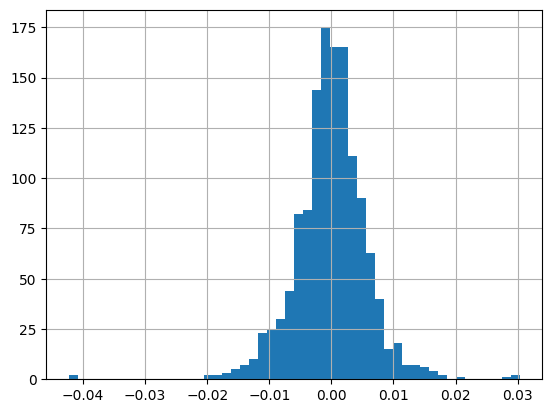

In [23]:
### Histograma de los retornos del tipo de cambio libra a dólar. 
log_returns_GBPUSD = calculateLogReturns(GBP_USD)
log_returns_GBPUSD.hist(bins = 50).plot()
plt.show()

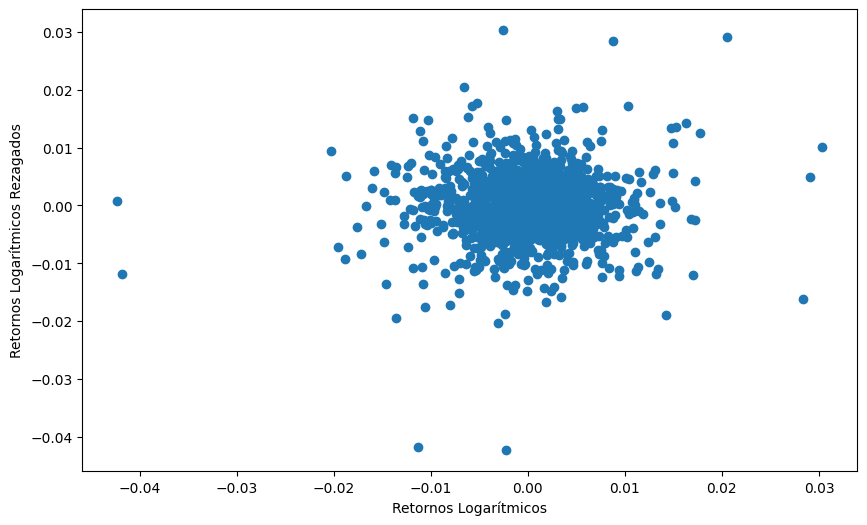

In [24]:
### Diagrama de dispersión de los retornos de los activos 

log_returns_GBPUSD_lagged = log_returns_GBPUSD.shift()

# Create scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(log_returns_GBPUSD, log_returns_GBPUSD_lagged)
plt.xlabel('Retornos Logarítmicos')
plt.ylabel('Retornos Logarítmicos Rezagados')
plt.show()

In [25]:
# Coeficiente de correlación entre los retornos actuales y los rezagados
correlation = log_returns_GBPUSD.corr(log_returns_GBPUSD_lagged)
print(f"Correlation coefficient: {correlation}")
# Como vemos el coeficiente de correlación dió muy cercano a cero indicando que efectivamente no hay correlación entre los retornos de hoy y los retornos 
# de ayer. 

Correlation coefficient: 0.03657689610319706


### 4. Simulación del precio de la tasa de cambio con modelo de movimiento browniano geométrico. 

Tomando la serie de la tasa de cambio de Libra a Dólar.

* Graficar precio ajustado de la tasa de cambio de Libra a Dólar.
* Graficar histograma con los retornos logarítmicos de la tasa de cambio Libra a dólar. 
* Realizar un diagrama de dispersión de la rentabilidad en el día t-1 vs la rentabilidad del día t. Calcular el coeficiente de correlación entre los mismos. 
* Realice una simulación usando el modelo de movimiento browniano geométrico 

Usando la siguiente definición de la ecuación del movimiento browniano. 

$dS_{t} = uS_{t}dt+\sigma S_{t}  d W_{t}$

Se puede llegar a la siguiente solución analítica para el precio spot del movimiento browniano geométrico. 

$ S_t = S_{0}(e^{(u -\frac{\sigma^{2}}{2})t + \sigma W_{t}}) $

In [26]:
# Coeficiente de drift
mu = log_returns_GBPUSD.mean()
# Número de pasos
n = 252
# Tiempo en años. 
T = 1
# Número de simulaciones.
M = 100
# Precio inicial de la acción. 
S0 = GBP_USD.iloc[-1]
# Volatilidad
sigma = log_returns_GBPUSD.std()
# Print the inputs 
print(mu, sigma)

-4.732139591000227e-05 0.0057572515453151235


In [27]:
### Imprimimos entonces los parámetros del movimiento browniano geométrico: 
### Retorno Anualizado. 
### Volatilidad Anualizada. 
print(mu*np.sqrt(252), log_returns_GBPUSD.std()*np.sqrt(252))

-0.0007512038716217704 0.09139353494487677


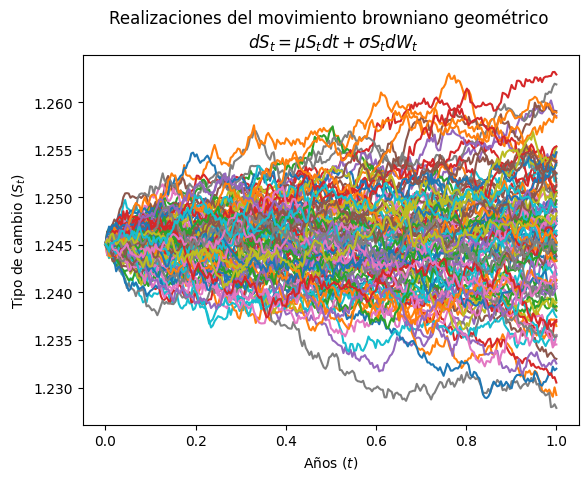

In [28]:
# calc each time step
dt = T/n

# simulation using numpy arrays
St = np.exp(
    (mu - sigma ** 2 / 2) * dt
    + sigma * np.random.normal(0, np.sqrt(dt), size=(M,n)).T
)

# include array of 1's
St = np.vstack([np.ones(M), St])

# multiply through by S0 and return the cumulative product of elements along a given simulation path (axis=0). 
St = S0 * St.cumprod(axis=0)

# Define time interval correctly 
time = np.linspace(0,T,n+1)

# Require numpy array that is the same shape as St
tt = np.full(shape=(M,n+1), fill_value=time).T

plt.plot(tt, St)
plt.xlabel("Años $(t)$")
plt.ylabel("Tipo de cambio $(S_t)$")
plt.title(
    "Realizaciones del movimiento browniano geométrico \n $dS_t = \mu S_t dt + \sigma S_t dW_t$"
)
plt.show()

### Referencias

Simulating Geometric Brownian Motion (GBM) in Python, QuantPy. (n.d.). Retrieved from https://quantpy.com.au/stochastic-calculus/simulating-geometric-brownian-motion-gbm-in-python/

Leong, L. (2022, January 19). How to test if trading algorithm performance is deteriorating. Gradient Growth. https://medium.com/gradient-growth/how-to-test-if-trading-algorithm-performance-is-deteriorating-30d469056a04

https://github.com/eduardohoc/Technical-Analysis-and-Backtest-Functions
